In [21]:
import csv
import pandas
import requests
from pprint import pprint
from vega import VegaLite
from collections import Counter, defaultdict

In [22]:
DATA = '../data/didascalies.csv'
GROUPES = 'https://www.nosdeputes.fr/organismes/groupe/json'

In [23]:
with open(DATA, 'r') as f:
    data = list(csv.DictReader(f))
df = pandas.read_table('../data/didascalies.csv', ',')
df.head()

,id,seance_id,date,moment,type,titre,titre_complet,timestamp,intervention,nb_mots,nom,parlementaire,sexe,parlementaire_groupe_acronyme,fonction,source,didascalie,groups,parlementaire_groupe_norme
0,1,1,2017-06-27,15:00,loi,NaN,NaN,20,<p>La séance est ouverte.</p>,7,NaN,Bernard Brochand,H,NI,"président, doyen d'âge",http://www.assemblee-nationale.fr/15/cri/2016-...,La séance est ouverte à quinze heures,NaN,NI
1,14,1,2017-06-27,15:00,loi,allocution du doyen d'âge,allocution du doyen d'âge,170,<p>Monsieur le secrétaire d'État chargé des re...,636,NaN,Bernard Brochand,H,NI,"président, doyen d'âge",http://www.assemblee-nationale.fr/15/cri/2016-...,Applaudissements,NaN,NI
2,17,1,2017-06-27,15:00,loi,Élection du président de l'assemblée nationale,Élection du président de l'assemblée nationale,220,"<p>L'ordre du jour appelle, conformément à l'a...",140,NaN,Bernard Brochand,H,NI,"président, doyen d'âge",http://www.assemblee-nationale.fr/15/cri/2016-...,Il est procédé au tirage au sort,NaN,NI
3,19,1,2017-06-27,15:00,loi,Élection du président de l'assemblée nationale,Élection du président de l'assemblée nationale,250,<p>Sont désignés scrutateurs titulaires : M. B...,51,NaN,Bernard Brochand,H,NI,"président, doyen d'âge",http://www.assemblee-nationale.fr/15/cri/2016-...,Il est procédé au tirage au sort,NaN,NI
4,24,1,2017-06-27,15:00,loi,Élection du président de l'assemblée nationale,Élection du président de l'assemblée nationale,320,<p>La séance est suspendue.</p>,7,NaN,Bernard Brochand,H,NI,"président, doyen d'âge",http://www.assemblee-nationale.fr/15/cri/2016-...,"La séance, suspendue à seize heures cinq, est ...",NaN,NI


In [27]:
groupes = {o["organisme"]["acronyme"]: o["organisme"] for o in requests.get(GROUPES).json()['organismes']}
print(groupes)

{'NI': {'id': 1, 'slug': 'deputes-non-inscrits', 'nom': 'Députés Non Inscrits', 'acronyme': 'NI', 'groupe_actuel': True, 'couleur': '165,165,165', 'order': 8, 'type': 'groupe', 'url_nosdeputes': 'https://www.nosdeputes.fr/organisme/deputes-non-inscrits', 'url_nosdeputes_api': 'https://www.nosdeputes.fr/organisme/deputes-non-inscrits/json'}, 'GDR': {'id': 8, 'slug': 'gauche-democrate-et-republicaine', 'nom': 'Gauche Démocrate et Républicaine', 'acronyme': 'GDR', 'groupe_actuel': True, 'couleur': '255,30,30', 'order': 1, 'type': 'groupe', 'url_nosdeputes': 'https://www.nosdeputes.fr/organisme/gauche-democrate-et-republicaine', 'url_nosdeputes_api': 'https://www.nosdeputes.fr/organisme/gauche-democrate-et-republicaine/json'}, 'LFI': {'id': 10, 'slug': 'la-france-insoumise', 'nom': 'La France Insoumise', 'acronyme': 'LFI', 'groupe_actuel': True, 'couleur': '204,42,70', 'order': 0, 'type': 'groupe', 'url_nosdeputes': 'https://www.nosdeputes.fr/organisme/la-france-insoumise', 'url_nosdeputes

In [169]:
def matrix(filt=None, normalize=False, nodiagonal=False):
    C = Counter()
    TOT = Counter()
    for r in data:
        if r["groups"] and r["parlementaire_groupe_norme"] != "NULL" and (not filt or re.search(filt, r["didascalie"], re.I)):
            for g in r["groups"].split("|"):
                TOT[g] += 1
                C[(r["parlementaire_groupe_norme"], g)] += 1
    rows = []
    for ((g1, g2), n) in C.items():
        rows.append({
            "orateur": g1,
            "order_ora": groupes[g1]["order"],
            "didascalie": g2,
            "order_did": groupes[g2]["order"],
            "total": 0 if (nodiagonal and g1 == g2) else (n/TOT[g2] if normalize else n)
        })
    #pprint(rows)
    return VegaLite({
      "mark": "rect",
      "encoding": {
        "y": {"field": "orateur", "type": "nominal", "sort": {"op": "mean", "field": "order_ora"}},
        "x": {"field": "didascalie", "type": "nominal", "sort": {"op": "mean", "field": "order_did"}},
        "color": {"field": "total", "type": "quantitative", "scale": {"type": "bib-ordinal"}}
      }
    }, rows)

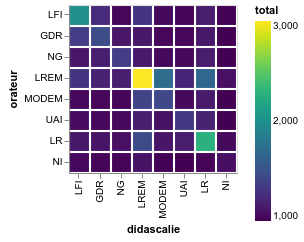

In [173]:
matrix()

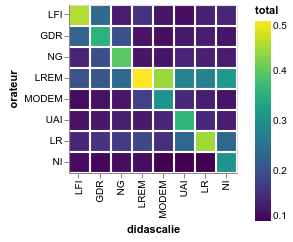

In [174]:
matrix(normalize=True)

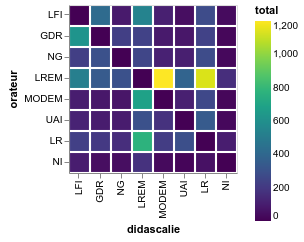

In [177]:
matrix(nodiagonal=True)

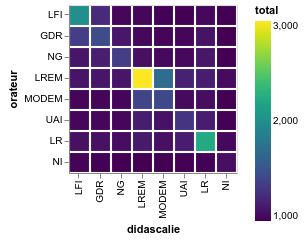

In [179]:
matrix("applaud")

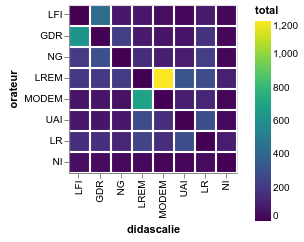

In [185]:
matrix("applaud", nodiagonal=True)

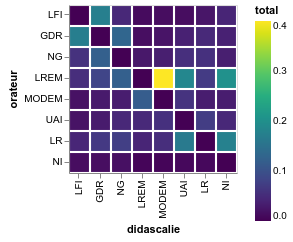

In [186]:
matrix("applaud", nodiagonal=True, normalize=True)

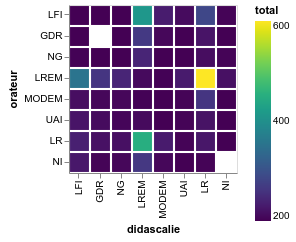

In [181]:
matrix("exclam")

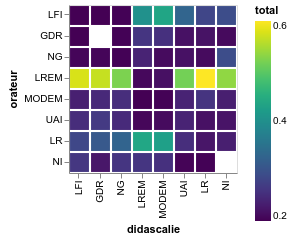

In [182]:
matrix("exclam", normalize=True)

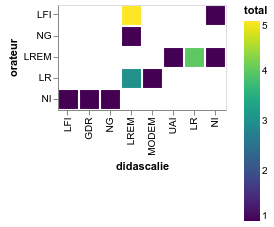

In [163]:
matrix("pupitre")

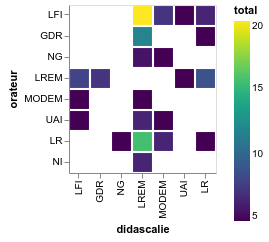

In [164]:
matrix("murmure")

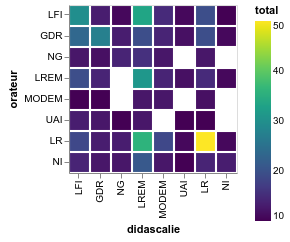

In [165]:
matrix("rires")